# Modelización de Inversión Publicitaria
El modelo de atribucio n analizara la relacio n entre la inversio n publicitaria y
los resultados comerciales, optimizando tanto el tra fico fí sico a las tiendas como la
tasa de conversio n de visitas en ventas.

### Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

### Cargar los datos

In [2]:
# Cargar los datos
df = pd.read_csv('datos_combinados.csv', parse_dates=['ID_Date'], index_col='ID_Date')

### Flags

In [3]:
# Configuración de flags - puedes activar/desactivar fácilmente cada componente
flags = {
    'incluir_inversiones': True,      # Incluir variables de inversión publicitaria
    'incluir_outcome_lag': True,      # Incluir variable objetivo rezagada (t-1)
    'incluir_trafico_web': True,      # Incluir variables de tráfico web
    'incluir_eventos': True,          # Incluir variables de eventos especiales
    'incluir_dias': True,             # Incluir variables de días (finde, laborables)
    'normalizar': True,               # Normalizar variables para el modelo Ridge
    'target': "Ratio_Ventas_Trafico"  # Variable objetivo a modelar
}

### Preparación de variables

In [4]:
# Preparar variables de inversión (convertir a porcentaje del total)
if flags['incluir_inversiones']:
    inv_columns = ['MMM05_INV_CINE', 'MMM05_INV_EXTERIOR', 'MMM05_INV_INTERNET', 
                   'MMM05_INV_PRENSA', 'MMM05_INV_PRODUCCION', 'MMM05_INV_RADIO', 
                   'MMM05_INV_REVISTAS', 'MMM05_INV_PlataformasVideo', 'MMM05_INV_VARIOS']
    df_inv_pct = df[inv_columns].div(df['MMM05_INV_INV_Total'], axis=0)
    df_inv_lag = df_inv_pct.shift(1)  # Lag de 1 mes

# Preparar variable objetivo rezagada
if flags['incluir_outcome_lag']:
    df['Ratio_Ventas_Trafico'] = df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']
    df_outcome_lag = df['Ratio_Ventas_Trafico'].shift(1).to_frame('Ratio_Ventas_Trafico_Lag1')

# Preparar variables de tráfico web
if flags['incluir_trafico_web']:
    web_columns = ['MMM01_WEB_Unique_visitors', 'MMM01_WEB_SocialNetworks', 
                   'MMM01_WEB_NaturalSearch', 'MMM01_WEB_PaidSearch']
    df_web = df[web_columns].shift(1)  # Lag de 1 mes

# Preparar variables de eventos
if flags['incluir_eventos']:
    df['Semana_Santa'] = df['MMM04_TIME_Easterweek']
    df['Black_Friday'] = (df.index.month == 11).astype(int)  # Asumiendo Noviembre
    df['Navidad'] = ((df.index.month == 12) | ((df.index.month == 11) & (df.index.day >= 25))).astype(int)
    df_events = df[['Semana_Santa', 'Black_Friday', 'Navidad']]

# Preparar variables de días
if flags['incluir_dias']:
    df['Fin_de_Semana'] = df['MMM04_TIME_Dias_fines_semana'] / df['MMM04_TIME_Dias_mes']  # Proporción
    df_dias = df[['Fin_de_Semana']]

### Construcción de la matriz de diseño

In [5]:
# Construir matriz de diseño inicial
df_design = pd.DataFrame(index=df.index)

# Añadir componentes según flags
if flags['incluir_inversiones']:
    df_design = df_design.join(df_inv_lag)
    
if flags['incluir_outcome_lag']:
    df_design = df_design.join(df_outcome_lag)
    
if flags['incluir_trafico_web']:
    df_design = df_design.join(df_web)
    
if flags['incluir_eventos']:
    df_design = df_design.join(df_events)
    
if flags['incluir_dias']:
    df_design = df_design.join(df_dias)

# Preparar variable objetivo
df_outcome = (df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']).to_frame('Ratio_Ventas_Trafico')

# Combinar todo y eliminar NAs
df_model = df_design.join(df_outcome).dropna()
print("Matriz de diseño (primeras filas):")
print(df_model.head())

Matriz de diseño (primeras filas):
            MMM05_INV_CINE  MMM05_INV_EXTERIOR  MMM05_INV_INTERNET  \
ID_Date                                                              
2022-02-01        0.104225            0.014271            0.232625   
2022-03-01        0.078877            0.103247            0.206517   
2022-04-01        0.149651            0.000000            0.582380   
2022-05-01        0.011563            0.000000            0.206991   
2022-06-01        0.099590            0.000000            0.175237   

            MMM05_INV_PRENSA  MMM05_INV_PRODUCCION  MMM05_INV_RADIO  \
ID_Date                                                               
2022-02-01          0.000000              0.010529         0.004223   
2022-03-01          0.010911              0.007310         0.000000   
2022-04-01          0.012244              0.010067         0.000000   
2022-05-01          0.051849              0.022897         0.001211   
2022-06-01          0.014738              0.0065

### Modelización con Ridge Regression
Usamos Ridge Regression para manejar multicolinealidad entre canales de inversión.

In [6]:
# Separar variables predictoras y objetivo
X = df_model.drop('Ratio_Ventas_Trafico', axis=1)
y = df_model['Ratio_Ventas_Trafico']

# Normalizar si está activado
if flags['normalizar']:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
else:
    X_scaled = X

# Ajustar modelo Ridge (sin train/test como solicitaste)
model = Ridge(alpha=1.0)
model.fit(X_scaled, y)

# Coeficientes del modelo
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_
}).sort_values('Coeficiente', ascending=False)

print("\nCoeficientes del modelo Ridge:")
print(coef_df)


Coeficientes del modelo Ridge:
                      Variable  Coeficiente
3             MMM05_INV_PRENSA     0.009283
9    Ratio_Ventas_Trafico_Lag1     0.009073
4         MMM05_INV_PRODUCCION     0.007920
13        MMM01_WEB_PaidSearch     0.007520
16                     Navidad     0.007437
5              MMM05_INV_RADIO     0.003642
7   MMM05_INV_PlataformasVideo     0.002839
11    MMM01_WEB_SocialNetworks     0.002428
1           MMM05_INV_EXTERIOR    -0.000232
15                Black_Friday    -0.000247
2           MMM05_INV_INTERNET    -0.000460
10   MMM01_WEB_Unique_visitors    -0.001055
14                Semana_Santa    -0.003695
6           MMM05_INV_REVISTAS    -0.005505
12     MMM01_WEB_NaturalSearch    -0.006064
0               MMM05_INV_CINE    -0.007005
8             MMM05_INV_VARIOS    -0.009855
17               Fin_de_Semana    -0.017878


### Visualización de resultados

<Figure size 1000x600 with 0 Axes>

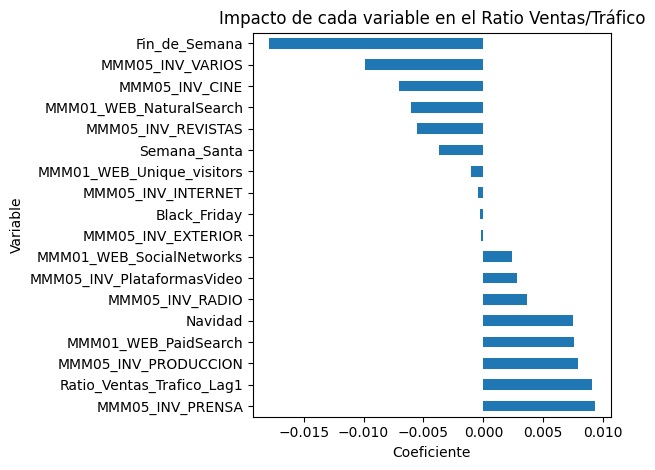

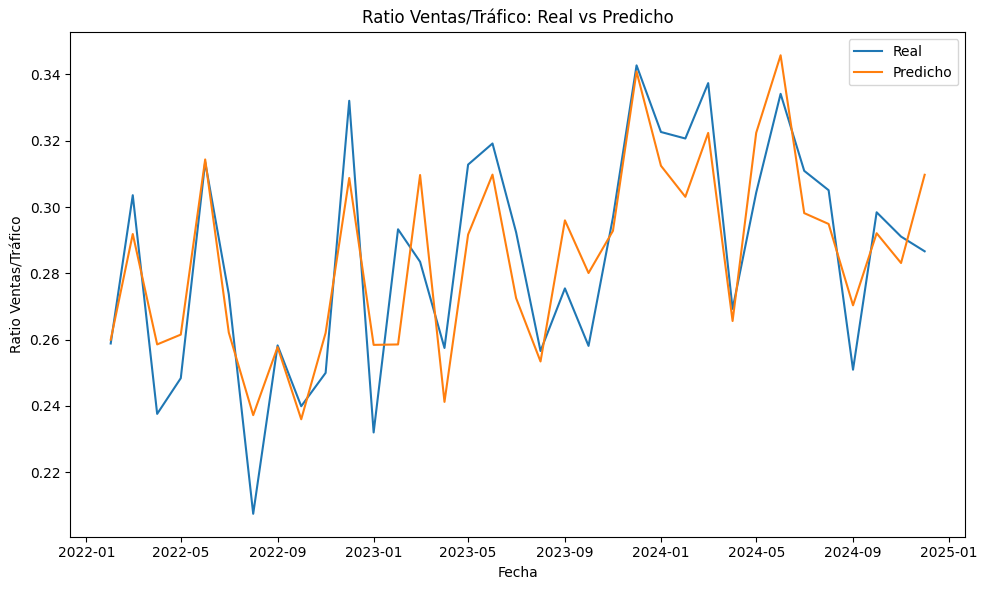

In [7]:
# Gráfico de coeficientes
plt.figure(figsize=(10, 6))
coef_df.plot(kind='barh', x='Variable', y='Coeficiente', legend=False)
plt.title('Impacto de cada variable en el Ratio Ventas/Tráfico')
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

# Gráfico de valores reales vs predichos
y_pred = model.predict(X_scaled)
plt.figure(figsize=(10, 6))
plt.plot(df_model.index, y, label='Real')
plt.plot(df_model.index, y_pred, label='Predicho')
plt.title('Ratio Ventas/Tráfico: Real vs Predicho')
plt.xlabel('Fecha')
plt.ylabel('Ratio Ventas/Tráfico')
plt.legend()
plt.tight_layout()
plt.show()

### Optimización de inversión
Variamos el porcentaje de inversión en cada canal (manteniendo los demás constantes) para encontrar el punto que maximiza el ratio ventas/tráfico.

In [8]:
# Encontrar el punto óptimo de inversión para cada canal
inv_optima = {}
total_inversion = df['MMM05_INV_INV_Total'].mean()  # Inversión promedio histórica

for canal in df_inv_pct.columns:
    # Crear escenarios variando la inversión en este canal (0% a 50% del presupuesto)
    escenarios = np.linspace(0, 0.5, 50)
    ratios_predichos = []
    
    for esc in escenarios:
        # Crear copia de los datos
        X_temp = X.copy()
        
        # Modificar solo este canal, manteniendo el resto igual
        if canal in X_temp.columns:
            X_temp[canal] = esc
            if flags['normalizar']:
                X_temp_scaled = scaler.transform(X_temp)
            else:
                X_temp_scaled = X_temp
            
            # Predecir ratio para este escenario
            ratio_pred = model.predict(X_temp_scaled)[-1]  # Último periodo
            ratios_predichos.append(ratio_pred)
    
    # Encontrar el máximo ratio predicho
    if ratios_predichos:
        idx_optimo = np.argmax(ratios_predichos)
        inv_optima[canal] = {
            'porcentaje_optimo': escenarios[idx_optimo],
            'ratio_maximo': ratios_predichos[idx_optimo],
            'inversion_optima': escenarios[idx_optimo] * total_inversion
        }

# Mostrar recomendaciones de inversión
print("\nRecomendaciones de inversión óptima:")
for canal, datos in inv_optima.items():
    print(f"{canal}:")
    print(f"  - Porcentaje óptimo: {datos['porcentaje_optimo']:.2%}")
    print(f"  - Inversión óptima mensual: {datos['inversion_optima']:,.0f} €")
    print(f"  - Ratio Ventas/Tráfico esperado: {datos['ratio_maximo']:.4f}\n")


Recomendaciones de inversión óptima:
MMM05_INV_CINE:
  - Porcentaje óptimo: 0.00%
  - Inversión óptima mensual: 0 €
  - Ratio Ventas/Tráfico esperado: 0.3144

MMM05_INV_EXTERIOR:
  - Porcentaje óptimo: 0.00%
  - Inversión óptima mensual: 0 €
  - Ratio Ventas/Tráfico esperado: 0.3097

MMM05_INV_INTERNET:
  - Porcentaje óptimo: 0.00%
  - Inversión óptima mensual: 0 €
  - Ratio Ventas/Tráfico esperado: 0.3102

MMM05_INV_PRENSA:
  - Porcentaje óptimo: 50.00%
  - Inversión óptima mensual: 288,254 €
  - Ratio Ventas/Tráfico esperado: 0.4855

MMM05_INV_PRODUCCION:
  - Porcentaje óptimo: 50.00%
  - Inversión óptima mensual: 288,254 €
  - Ratio Ventas/Tráfico esperado: 0.4025

MMM05_INV_RADIO:
  - Porcentaje óptimo: 50.00%
  - Inversión óptima mensual: 288,254 €
  - Ratio Ventas/Tráfico esperado: 0.3874

MMM05_INV_REVISTAS:
  - Porcentaje óptimo: 0.00%
  - Inversión óptima mensual: 0 €
  - Ratio Ventas/Tráfico esperado: 0.3108

MMM05_INV_PlataformasVideo:
  - Porcentaje óptimo: 50.00%
  - Inve